<a href="https://colab.research.google.com/github/hmin27/2023_DL_Clip/blob/main/Linear_Probe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CLIP Fewshot Linear Probe
- 1, 2, 4, 8, 16 shots



In [1]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

In [29]:
import os
import clip
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

BATCH_SIZE = 8

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Prepare the Model and Data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device, jit=False)
model = model.to(torch.float32)

100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 147MiB/s]


# Training

Accuracy on 1-shot data: 54.55%
Accuracy on 2-shot data: 75.76%
Accuracy on 4-shot data: 84.85%
Accuracy on 8-shot data: 93.18%
Accuracy on 16-shot data: 93.18%


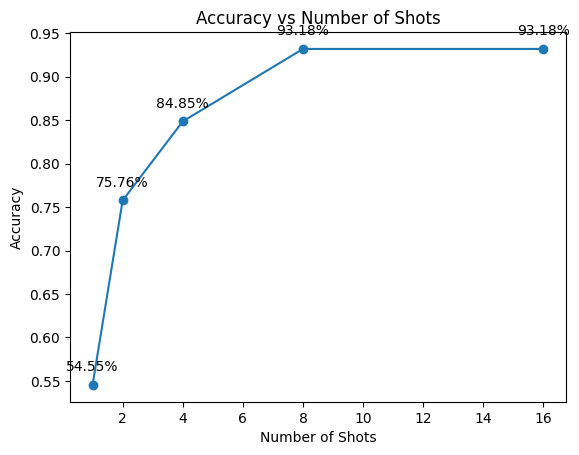

In [31]:
model = model.eval()

# Load your few-shot data
data_folder_base = '/content/drive/MyDrive/Study/DL_CLIP/Food_fewshot/{}_shot/{}'
shot_list = [1, 2, 4, 8, 16]
accuracies = []

for num_shots in shot_list:
    data_folder_train = data_folder_base.format(num_shots, 'train')
    data_folder_test = data_folder_base.format(num_shots, 'test')

    train_dataset = ImageFolder(root=data_folder_train, transform=preprocess)
    test_dataset = ImageFolder(root=data_folder_test, transform=preprocess)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # Extract features from the CLIP model
    def get_features(dataset):
        all_features = []
        all_labels = []

        with torch.no_grad():
            for images, labels in DataLoader(dataset, batch_size=BATCH_SIZE):
                images = images.to(device)
                features = model.encode_image(images)
                all_features.append(features)
                all_labels.append(labels)

        return torch.cat(all_features).cpu().numpy(), torch.cat(all_labels).cpu().numpy()

    train_features, train_labels = get_features(train_dataset)
    test_features, test_labels = get_features(test_dataset)

    # Perform logistic regression with the extracted features
    classifier = LogisticRegression(random_state=0, C=0.316, max_iter=1000, verbose=1)
    classifier.fit(train_features, train_labels)

    # Evaluate using the logistic regression classifier
    predictions = classifier.predict(test_features)
    accuracy = accuracy_score(test_labels, predictions)
    accuracies.append(accuracy)
    print(f"Accuracy on {num_shots}-shot data: {accuracy * 100:.2f}%")

# Plot the accuracies
plt.plot(shot_list, accuracies, marker='o')
for i, txt in enumerate(accuracies):
    plt.annotate(f'{txt * 100:.2f}%', (shot_list[i], accuracies[i]), textcoords="offset points", xytext=(0,10), ha='center')
plt.title('Accuracy vs Number of Shots')
plt.xlabel('Number of Shots')
plt.ylabel('Accuracy')
plt.show()